## About Dataset
### Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

## Content
The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.


## Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.



In [66]:
#!pip install -U pip
#!pip install -U setuptools wheel
#!pip install -U "mxnet<2.0.0" bokeh==2.0.1
#!pip install autogluon --no-cache-dir
#!pip install missingno
#!pip install smdebug

In [3]:
import os
import sys
import boto3
import sagemaker
from time import sleep
from collections import Counter
import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor  
from sagemaker import get_execution_role, local, Model, utils, s3
from sagemaker.estimator import Estimator
from sagemaker.predictor import Predictor
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import StringDeserializer
from sklearn.metrics import accuracy_score, classification_report
from IPython.core.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
%matplotlib inline
session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "sagemaker/autogluon-tabular"
region = session.boto_region_name
role = get_execution_role()
client = session.boto_session.client("sts", region_name=region, endpoint_url=utils.sts_regional_endpoint(region))

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  Data Preparation

In [4]:
df = pd.read_csv('diabetes.csv')

In [5]:
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

## Get column names

In [6]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

## EDA

In [7]:
df.shape

(768, 9)

In [8]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
df.describe().T

count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   
Outcome                   768.0    0.348958    0.476951   0.000   0.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                    30.5000  127.25000  846.00  
BMI                        32.0000   36.60000   67.10  
DiabetesPedigreeFunction    0.3725    0.62625    2.42  
Age                        29.0000   41.00000   81.00  
Outcome                     0.0000    1.00000    1.00

### The results of this summary of describe function.
There are some value of below listed columns have zero minimum, the value of zero does indicates missing value.

Following columns or variables have an invalid zero value:

 - Glucose
 - BloodPressure
 - SkinThickness
 - Insulin
 - BMI

These missing values can be replaced by nan this will help in counting.

## Ploting Data Distribution

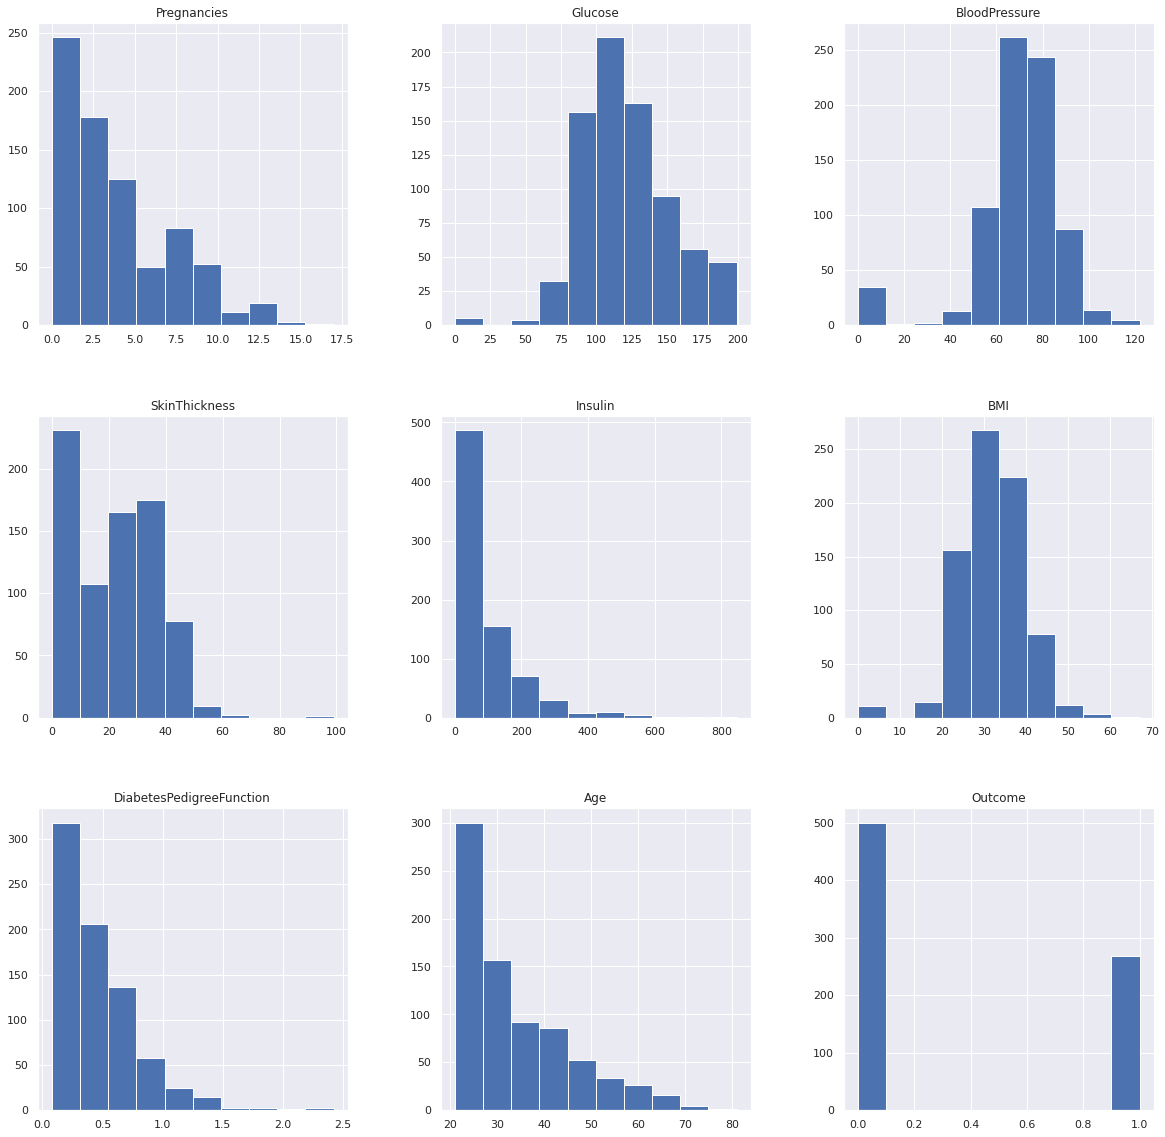

In [10]:
plot= df.hist(figsize = (20,20))
plt.savefig('unclean.jpg')

In [11]:
df_copy = df.copy(deep = True)
df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
print(df_copy.isnull().sum())

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


## Replacing nan values for the columns in accordance with their distribution


In [12]:
df_copy['Glucose'].fillna(df_copy['Glucose'].mean(), inplace = True)
df_copy['BloodPressure'].fillna(df_copy['BloodPressure'].mean(), inplace = True)
df_copy['SkinThickness'].fillna(df_copy['SkinThickness'].median(), inplace = True)
df_copy['Insulin'].fillna(df_copy['Insulin'].median(), inplace = True)
df_copy['BMI'].fillna(df_copy['BMI'].median(), inplace = True)



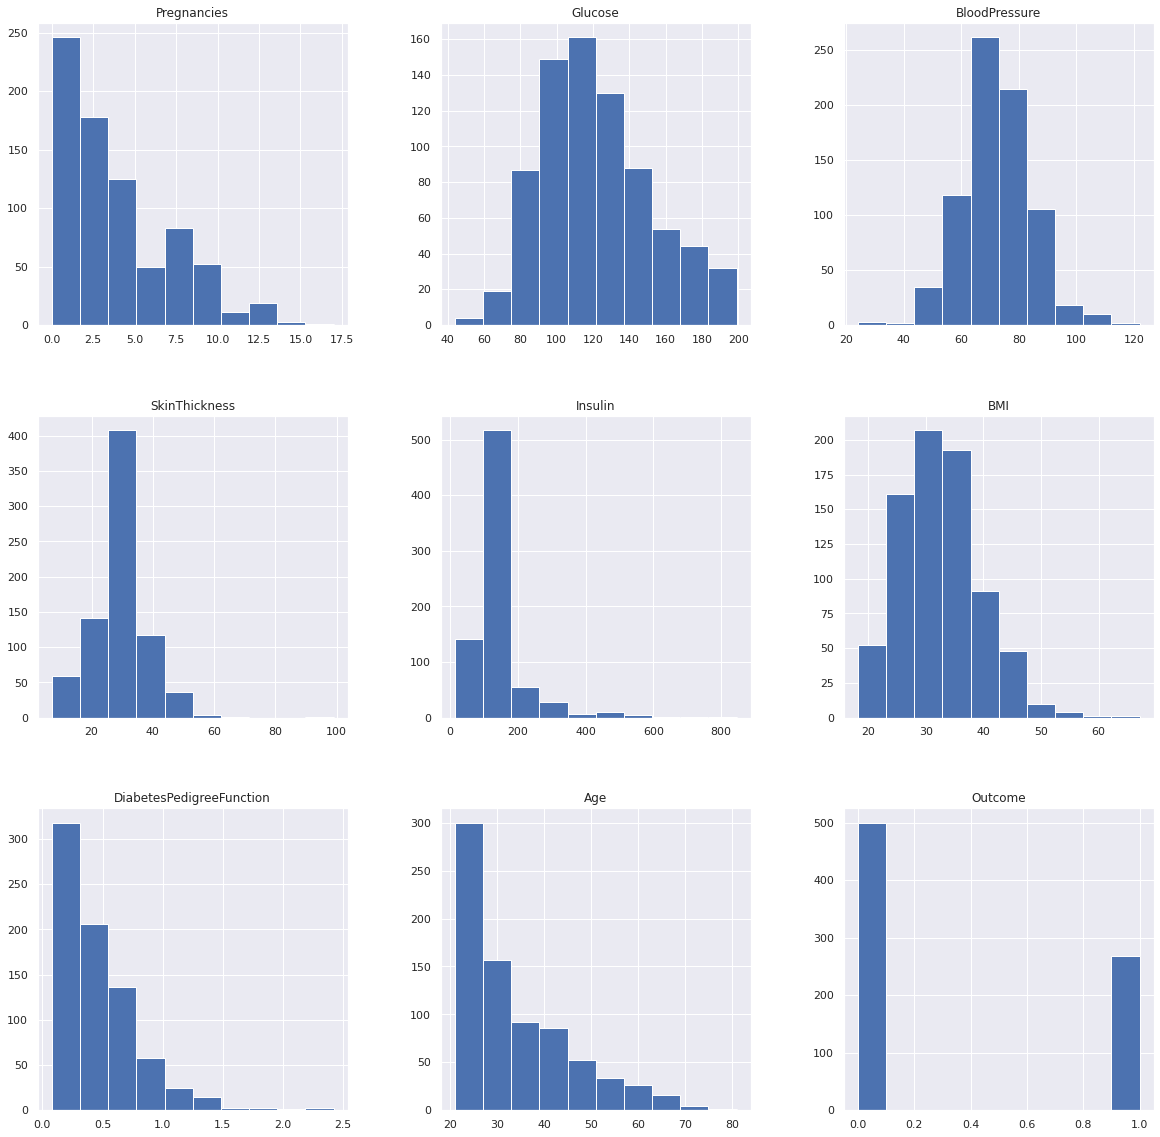

In [13]:
_=df_copy.hist(figsize =(20,20))
plt.savefig('clean.jpg')

## null count analysis



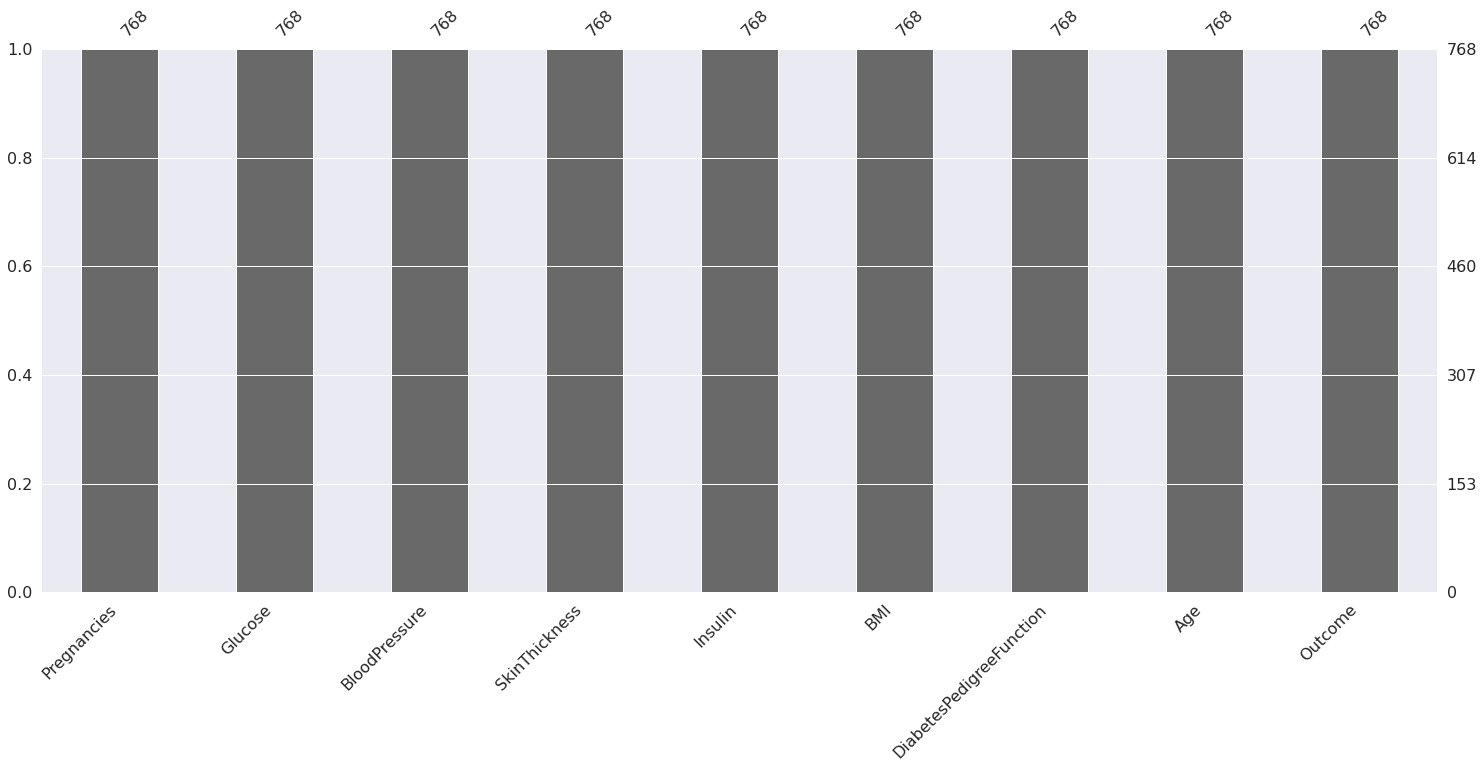

In [14]:
p=msno.bar(df)

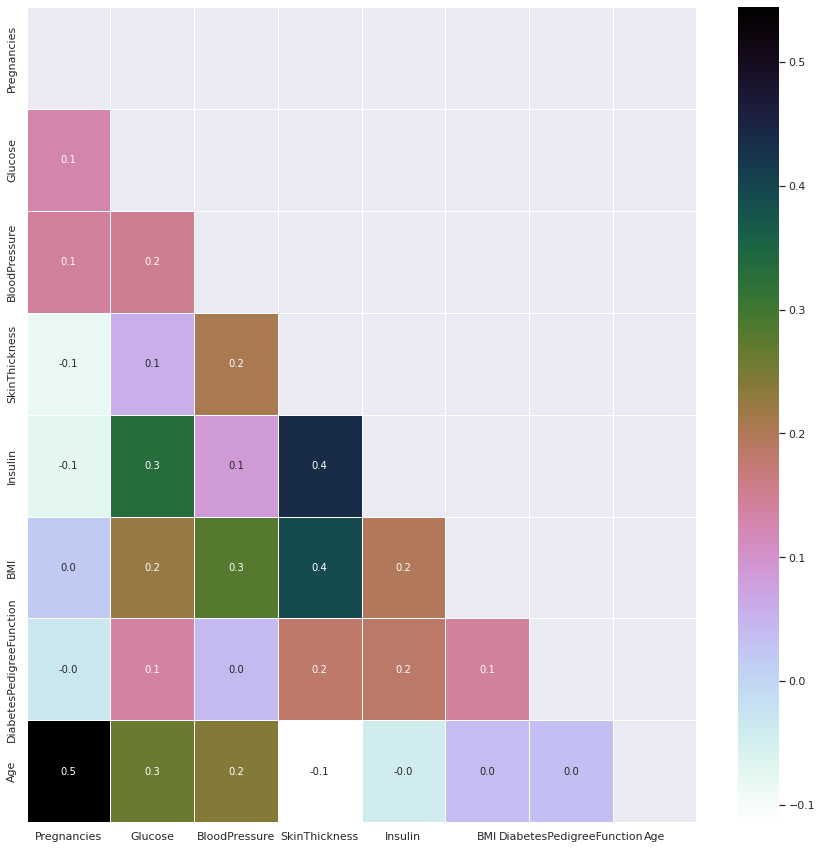

In [15]:
# Correlation visualisation
# Heatmap is good method to visualize correlation between features.
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness','Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
f,ax = plt.subplots(figsize=(15,15))
matrix = np.triu(df[cols].corr())
sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, fmt='.1f',mask=matrix, ax=ax,cmap='cubehelix_r')
plt.savefig('Corr.jpg')

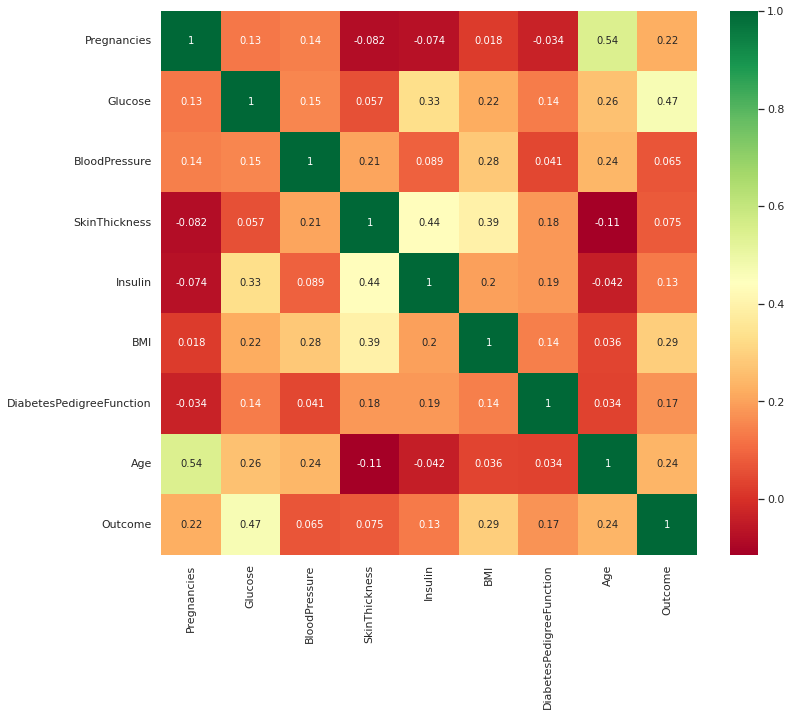

In [16]:
plt.figure(figsize=(12,10)) 
p=sns.heatmap(df.corr(), annot=True,cmap ='RdYlGn')

In [17]:
truediabetes= df.loc[df['Outcome']==1]
truediabetes.mean()


Pregnancies                   4.865672
Glucose                     141.257463
BloodPressure                70.824627
SkinThickness                22.164179
Insulin                     100.335821
BMI                          35.142537
DiabetesPedigreeFunction      0.550500
Age                          37.067164
Outcome                       1.000000
dtype: float64

In [18]:
falsediabetes= df.loc[df['Outcome']==0]
falsediabetes.mean()


Pregnancies                   3.298000
Glucose                     109.980000
BloodPressure                68.184000
SkinThickness                19.664000
Insulin                      68.792000
BMI                          30.304200
DiabetesPedigreeFunction      0.429734
Age                          31.190000
Outcome                       0.000000
dtype: float64

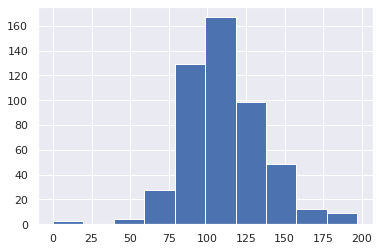

In [19]:
F = df.loc[df['Outcome'] == 0, 'Glucose'].hist()


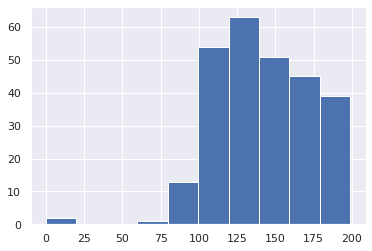

In [20]:
T= df.loc[df['Outcome']==1, 'Glucose'].hist()


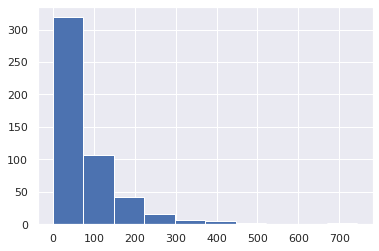

In [21]:
FI = df.loc[df['Outcome']==0, 'Insulin'].hist()


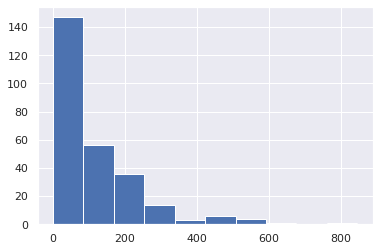

In [22]:
TI = df.loc[df['Outcome']==1, 'Insulin'].hist()


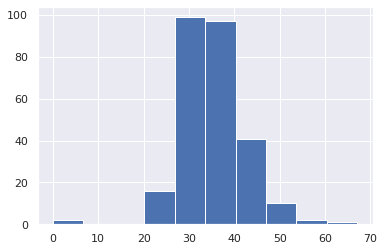

In [23]:
TB = df.loc[df['Outcome']==1, 'BMI'].hist()


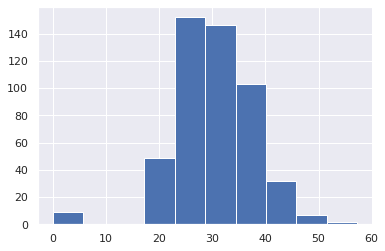

In [24]:
FB = df.loc[df['Outcome']==0, 'BMI'].hist()


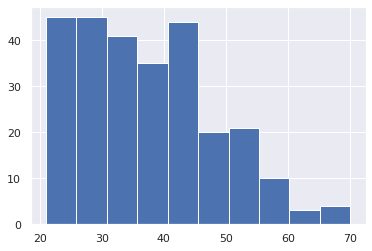

In [25]:
TA = df.loc[df['Outcome']==1, 'Age'].hist()


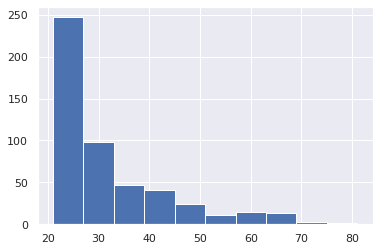

In [26]:
FA = df.loc[df['Outcome']==0, 'Age'].hist()

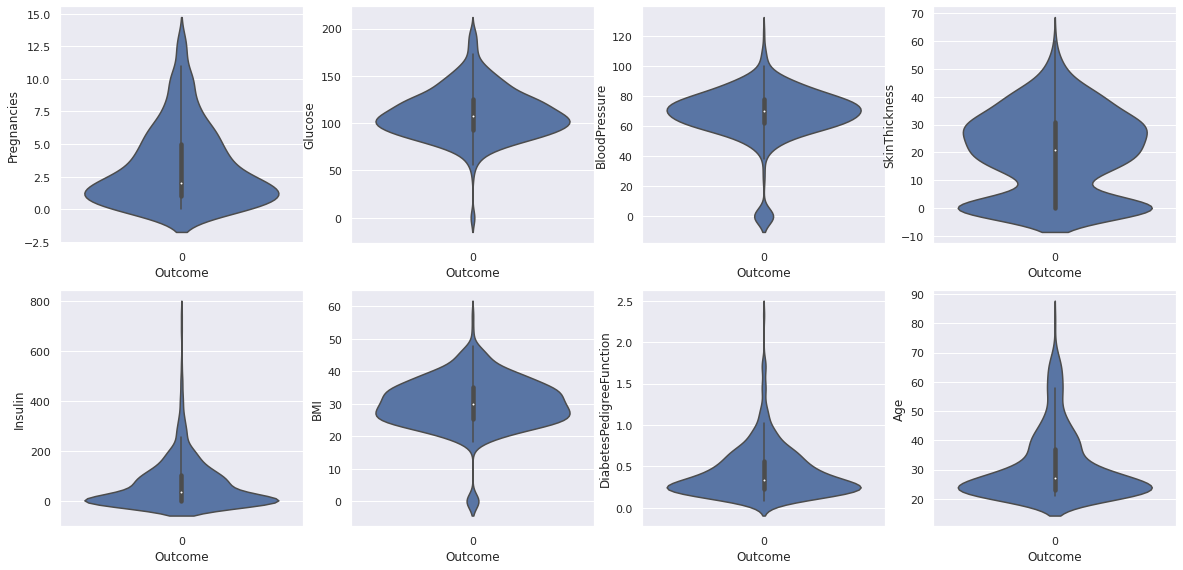

In [27]:
plt.figure(figsize=(20, 20))

for column_index, column in enumerate(falsediabetes.columns):
    if column == 'Outcome':
        continue
    plt.subplot(4, 4, column_index + 1)
    sns.violinplot(x='Outcome', y=column, data=falsediabetes)
    plt.savefig('falsediab.jpg')

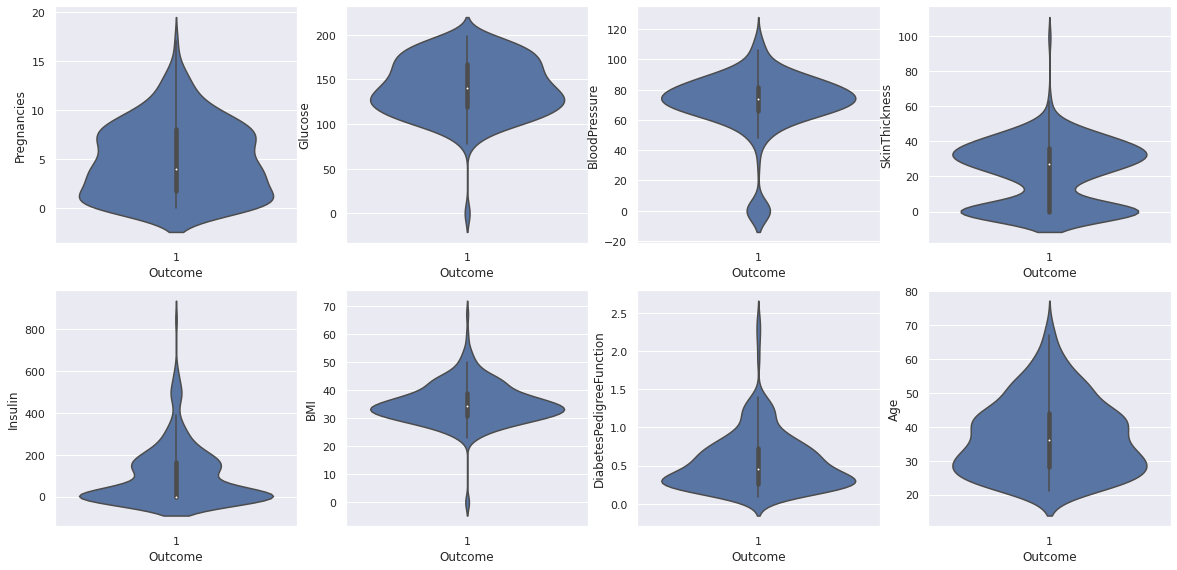

In [28]:
plt.figure(figsize=(20, 20))

for column_index, column in enumerate(truediabetes.columns):
    if column == 'Outcome':
        continue
    plt.subplot(4, 4, column_index + 1)
    sns.violinplot(x='Outcome', y=column, data=truediabetes)
    plt.savefig('truediab.jpg')

# Split train/test data

In [29]:

train = df.sample(frac=0.7, random_state=42)
test = df.drop(train.index)

label = "Outcome"
y_test = test[label]
X_test = test.drop(columns=[label])


In [30]:
train.head(3)
train.shape



(538, 9)

In [31]:
test.head(3)
test.shape

(230, 9)

In [32]:
X_test.head(3)
X_test.shape


(230, 8)

## Benchmark Model


In [33]:
!pip install graphviz


In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree

In [35]:
X=df[df.columns[0:-1]]
Y=df[df.columns[-1]]


X_train,X_test,y_train,y_test = train_test_split(X,Y,stratify=Y,random_state=42)
clf = DecisionTreeClassifier(max_depth=4,random_state=0)
clf.fit(X_train,y_train)
print("Accuracy on training set: {:.3f}".format(clf.score(X_train,y_train)))
print("Accuracy on test set: {:.3f}".format(clf.score(X_test,y_test)))

Accuracy on training set: 0.818
Accuracy on test set: 0.766


## Evaluate

In [36]:
test_pred_decision_tree = clf.predict(X_test)
test_pred_decision_tree

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0])

## Upload data to S3

In [37]:
train_file = "train.csv"
train.to_csv(train_file, index=False)
train_s3_path = session.upload_data(train_file, key_prefix="{}/data".format(prefix))

test_file = "test.csv"
test.to_csv(test_file, index=False)
test_s3_path = session.upload_data(test_file, key_prefix="{}/data".format(prefix))


X_test_file = "X_test.csv"
X_test.to_csv(X_test_file, index=False)
X_test_s3_path = session.upload_data(X_test_file, key_prefix="{}/data".format(prefix))

## Model Hyperparameter Selection


**Requirements:

We are predicting outcome, so it is the label we are setting.
Set a time limit of 10 minutes (600 seconds).
Use the preset best_quality to focus on creating the best model optimize_for_deployemnt for inference

## Train

In [38]:
%%time

predictor = TabularPredictor(label='Outcome', 
                             eval_metric='roc_auc',
                             ).fit(train_data=train_s3_path,
                                  time_limit=600,
                                  presets=['best_quality', 'optimize_for_deployment'],
                                 )

No path specified. Models will be saved in: "AutogluonModels/ag-20230315_050334/"
Presets specified: ['best_quality', 'optimize_for_deployment']
Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/train.csv | Columns = 9 / 9 | Rows = 538 -> 538
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230315_050334/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Feb 1 21:34:38 UTC 2023
Train Data Rows:    538
Train Data Columns: 8
Label Column: Outcome
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (

CPU times: user 10.9 s, sys: 1.56 s, total: 12.4 s
Wall time: 9min 25s


In [39]:
predictor.fit_summary(show_plot=True)


*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   0.849699       0.947652  238.621253                0.000477           0.432110            2       True          4
1       LightGBMXT_BAG_L1   0.848956       0.066890   40.488164                0.066890          40.488164            1       True          1
2  NeuralNetFastAI_BAG_L1   0.831127       0.383759  102.190960                0.383759         102.190960            1       True          2
3   NeuralNetTorch_BAG_L1   0.830445       0.496527   95.510019                0.496527          95.510019            1       True          3
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_TabularNeuralNetTorch', 'StackerEnsembleModel_LGB', 'StackerEnsembleModel_NNFastAiTabular'}
Bagging used: True  (with 5 folds)


{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': 0.8489562013917314,
  'NeuralNetFastAI_BAG_L1': 0.8311274844226133,
  'NeuralNetTorch_BAG_L1': 0.8304452631100195,
  'WeightedEnsemble_L2': 0.8496990645987781},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT_BAG_L1': 'AutogluonModels/ag-20230315_050334/models/LightGBMXT_BAG_L1/',
  'NeuralNetFastAI_BAG_L1': 'AutogluonModels/ag-20230315_050334/models/NeuralNetFastAI_BAG_L1/',
  'NeuralNetTorch_BAG_L1': 'AutogluonModels/ag-20230315_050334/models/NeuralNetTorch_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230315_050334/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'LightGBMXT_BAG_L1': 40.48816418647766,
  'NeuralNetFastAI_BAG_L1': 102.1909601688385,
  'Ne

### Create predictions from test dataset


### Monitoring

In [59]:
predictor.leaderboard()

                    model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   0.849699       0.947987  235.299451                0.000524           0.249235            2       True          4
1       LightGBMXT_BAG_L1   0.848956       0.128012   40.415414                0.128012          40.415414            1       True          1
2  NeuralNetFastAI_BAG_L1   0.831127       0.355836  100.760741                0.355836         100.760741            1       True          2
3   NeuralNetTorch_BAG_L1   0.830445       0.463615   93.874062                0.463615          93.874062            1       True          3


model  score_val  pred_time_val    fit_time  \
0     WeightedEnsemble_L2   0.849699       0.947987  235.299451   
1       LightGBMXT_BAG_L1   0.848956       0.128012   40.415414   
2  NeuralNetFastAI_BAG_L1   0.831127       0.355836  100.760741   
3   NeuralNetTorch_BAG_L1   0.830445       0.463615   93.874062   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                0.000524           0.249235            2       True   
1                0.128012          40.415414            1       True   
2                0.355836         100.760741            1       True   
3                0.463615          93.874062            1       True   

   fit_order  
0          4  
1          1  
2          2  
3          3

<AxesSubplot:xlabel='model'>

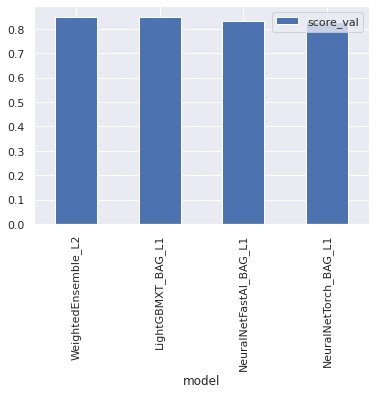

In [60]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

## Predicting

### Predicting for each row

In [41]:
predictions = predictor.predict(test_s3_path)
predictions.head()

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230


0    0
1    1
2    1
3    1
4    1
Name: Outcome, dtype: int64

### Probabilities for classification

In [42]:
predictor.predict_proba(test_s3_path)


Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230


0         1
0    0.909209  0.090791
1    0.284950  0.715050
2    0.288398  0.711602
3    0.266683  0.733317
4    0.436233  0.563767
..        ...       ...
225  0.636808  0.363192
226  0.514149  0.485851
227  0.376166  0.623834
228  0.120273  0.879727
229  0.827849  0.172151

[230 rows x 2 columns]

### Evaluate

In [43]:
predictor.evaluate(test_s3_path)

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230
Evaluation: roc_auc on test data: 0.8274792522424343
Evaluations on test data:
{
    "roc_auc": 0.8274792522424343,
    "accuracy": 0.7478260869565218,
    "balanced_accuracy": 0.6872327940313522,
    "mcc": 0.41186364034362855,
    "f1": 0.5735294117647058,
    "precision": 0.6842105263157895,
    "recall": 0.4936708860759494
}


{'roc_auc': 0.8274792522424343,
 'accuracy': 0.7478260869565218,
 'balanced_accuracy': 0.6872327940313522,
 'mcc': 0.41186364034362855,
 'f1': 0.5735294117647058,
 'precision': 0.6842105263157895,
 'recall': 0.4936708860759494}

# Fine tuning hyperparamters for retraining

In [44]:
%%time

predictor = TabularPredictor(label='Outcome', 
                             eval_metric='roc_auc',
                             ).fit(train_data=train_s3_path,
                                  time_limit=600,
                                  presets=['best_quality', 'optimize_for_deployment'],
                                  hyperparameters='very_light',
                                  )

No path specified. Models will be saved in: "AutogluonModels/ag-20230315_051304/"
Presets specified: ['best_quality', 'optimize_for_deployment']
Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/train.csv | Columns = 9 / 9 | Rows = 538 -> 538
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20230315_051304/"
AutoGluon Version:  0.7.0
Python Version:     3.8.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Feb 1 21:34:38 UTC 2023
Train Data Rows:    538
Train Data Columns: 8
Label Column: Outcome
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (

CPU times: user 6.28 s, sys: 956 ms, total: 7.24 s
Wall time: 9min 12s


### Monitoring

In [45]:
predictor.leaderboard()

                    model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   0.849699       0.947987  235.299451                0.000524           0.249235            2       True          4
1       LightGBMXT_BAG_L1   0.848956       0.128012   40.415414                0.128012          40.415414            1       True          1
2  NeuralNetFastAI_BAG_L1   0.831127       0.355836  100.760741                0.355836         100.760741            1       True          2
3   NeuralNetTorch_BAG_L1   0.830445       0.463615   93.874062                0.463615          93.874062            1       True          3


model  score_val  pred_time_val    fit_time  \
0     WeightedEnsemble_L2   0.849699       0.947987  235.299451   
1       LightGBMXT_BAG_L1   0.848956       0.128012   40.415414   
2  NeuralNetFastAI_BAG_L1   0.831127       0.355836  100.760741   
3   NeuralNetTorch_BAG_L1   0.830445       0.463615   93.874062   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                0.000524           0.249235            2       True   
1                0.128012          40.415414            1       True   
2                0.355836         100.760741            1       True   
3                0.463615          93.874062            1       True   

   fit_order  
0          4  
1          1  
2          2  
3          3

<AxesSubplot:xlabel='model'>

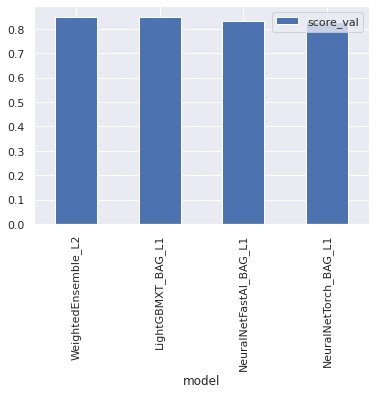

In [55]:
predictor.leaderboard(silent=True).plot(kind="bar", x="model", y="score_val")

In [46]:
predictions = predictor.predict(test_s3_path)
predictions.head()

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230


0    0
1    1
2    1
3    1
4    1
Name: Outcome, dtype: int64

In [47]:
predictor.predict_proba(test_s3_path)

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230


0         1
0    0.909209  0.090791
1    0.284950  0.715050
2    0.288398  0.711602
3    0.266683  0.733317
4    0.436233  0.563767
..        ...       ...
225  0.636808  0.363192
226  0.514149  0.485851
227  0.376166  0.623834
228  0.120273  0.879727
229  0.827849  0.172151

[230 rows x 2 columns]

### Trained models

In [48]:
predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                    model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2   0.849699       0.947987  235.299451                0.000524           0.249235            2       True          4
1       LightGBMXT_BAG_L1   0.848956       0.128012   40.415414                0.128012          40.415414            1       True          1
2  NeuralNetFastAI_BAG_L1   0.831127       0.355836  100.760741                0.355836         100.760741            1       True          2
3   NeuralNetTorch_BAG_L1   0.830445       0.463615   93.874062                0.463615          93.874062            1       True          3
Number of models trained: 4
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_TabularNeuralNetTorch', 'StackerEnsembleModel_LGB', 'StackerEnsembleModel_NNFastAiTabular'}
Bagging used: True  (with 5 folds)


{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': 0.8489562013917314,
  'NeuralNetFastAI_BAG_L1': 0.8311274844226133,
  'NeuralNetTorch_BAG_L1': 0.8304452631100195,
  'WeightedEnsemble_L2': 0.8496990645987781},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT_BAG_L1': 'AutogluonModels/ag-20230315_051304/models/LightGBMXT_BAG_L1/',
  'NeuralNetFastAI_BAG_L1': 'AutogluonModels/ag-20230315_051304/models/NeuralNetFastAI_BAG_L1/',
  'NeuralNetTorch_BAG_L1': 'AutogluonModels/ag-20230315_051304/models/NeuralNetTorch_BAG_L1/',
  'WeightedEnsemble_L2': 'AutogluonModels/ag-20230315_051304/models/WeightedEnsemble_L2/'},
 'model_fit_times': {'LightGBMXT_BAG_L1': 40.41541385650635,
  'NeuralNetFastAI_BAG_L1': 100.7607409954071,
  'Ne

## Importance of each feature

In [49]:
predictor.feature_importance(test_s3_path)

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230
Computing feature importance via permutation shuffling for 8 features using 230 rows with 5 shuffle sets...
	44.08s	= Expected runtime (8.82s per shuffle set)
	11.36s	= Actual runtime (Completed 5 of 5 shuffle sets)


importance    stddev   p_value  n  p99_high  \
Glucose                     0.147188  0.030706  0.000215  5  0.210412   
BMI                         0.049409  0.015868  0.001118  5  0.082080   
Age                         0.022550  0.009039  0.002531  5  0.041161   
Insulin                     0.007880  0.003649  0.004235  5  0.015394   
DiabetesPedigreeFunction    0.006706  0.008297  0.072490  5  0.023790   
BloodPressure               0.001542  0.002284  0.102763  5  0.006245   
Pregnancies                 0.001392  0.008936  0.372610  5  0.019790   
SkinThickness              -0.004778  0.002191  0.995911  5 -0.000267   

                           p99_low  
Glucose                   0.083963  
BMI                       0.016738  
Age                       0.003939  
Insulin                   0.000366  
DiabetesPedigreeFunction -0.010377  
BloodPressure            -0.003160  
Pregnancies              -0.017007  
SkinThickness            -0.009289

## Get a list of string names

In [50]:
models = predictor.get_model_names()

## Predict with the 2nd model

In [51]:
predictor.predict(test_s3_path, model=models[1])

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230


0      0
1      1
2      1
3      1
4      1
      ..
225    1
226    0
227    1
228    1
229    0
Name: Outcome, Length: 230, dtype: int64

In [57]:
performance = predictor.evaluate(test_s3_path, model=models[3])

Loaded data from: s3://sagemaker-us-east-1-495962688195/sagemaker/autogluon-tabular/data/test.csv | Columns = 9 / 9 | Rows = 230 -> 230
Evaluation: roc_auc on test data: 0.8274792522424343
Evaluations on test data:
{
    "roc_auc": 0.8274792522424343,
    "accuracy": 0.7478260869565218,
    "balanced_accuracy": 0.6872327940313522,
    "mcc": 0.41186364034362855,
    "f1": 0.5735294117647058,
    "precision": 0.6842105263157895,
    "recall": 0.4936708860759494
}
